In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX, MVNormal, MVNormalRW, Linear, CFlow, LinearChol
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky

np.random.seed(1234)

In [2]:
data = pd.read_csv('./data/test_rus_data.csv').values.astype(floatX).T[np.newaxis][:,2:]/100

In [3]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.21742282 0.16835931 0.01139835]


In [4]:
xs = data

In [5]:
n = data.shape[1]
s1 = 0.01
s0 = 2.
dim = [3,4]

k = dim[0] * dim[1]
# with tf.variable_scope('pwalk_inf', reuse=tf.AUTO_REUSE):
#     lowerd = DFlow([NVPFlow(dim=k*(k-1)//2 + k, name='lowerd_flow_' + str(i)) for i in range(2)])
#     ldiag = DFlow([NVPFlow(dim=k, name='ldiag_flow_' + str(i)) for i in range(4)])
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior', 
#                    lowerd=lowerd.output[0], ldiag=ldiag.output[0]+np.log(1/s1))
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')
PWalk = NormalRW(dim=None, sigma0=s0, sigma=s1)

In [6]:
def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [7]:
init = np.array([[ 0.0309,  0.0638, -0.1418, -0.1054,  0.1332,  0.2403,  0.5305, 
                  0.2873,  0.1176, -0.0548,  0.9631,  0.0343]])[np.newaxis]
out_flow = DFlow([LinearChol(n*dim[0]*dim[1], name='approx')])
outputs = tf.reshape(out_flow.output, [1, n, dim[0]*dim[1]])
outputs += init
# out_flow = DFlow([LinearChol(dim[0]*dim[1], name='approx')])
# outputs = tf.stack([out_flow.output]*n)

In [8]:
outputs

<tf.Tensor 'add_3:0' shape=(1, 20, 12) dtype=float64>

In [9]:
prior = PWalk.logdens(outputs)

In [10]:
prior

<tf.Tensor 'add_6:0' shape=() dtype=float64>

In [11]:
def create_loglik2():
    obs_d = Normal(dim=None, sigma=1., mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float64)
    return obs_d.logdens(ar - xs[0][1:])

In [12]:
logl = create_loglik2()

In [13]:
ent = out_flow.logdens

In [14]:
ent

<tf.Tensor 'sub_1:0' shape=() dtype=float64>

In [15]:
df = dim[0]*dim[1]*5
pmat = np.diag([(1/s1**2)]*(dim[0]*dim[1]))/df
cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)

In [16]:
loss = -logl - prior + ent# - cov_prior.log_prob(PWalk.fsigma) + lowerd.logdens + ldiag.logdens
loss /= n*dim[0]*dim[1]

In [17]:
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [18]:
opt = tf.train.FtrlOptimizer(#AdamOptimizer(0.001).minimize(loss)

In [19]:
sess = tf.InteractiveSession()

In [20]:
tf.global_variables_initializer().run()

In [21]:
prior.eval(), ent.eval(), logl.eval()

(-4010934.7500033253, -362.67217300760683, -2336.008498405986)

In [22]:
loss.eval()

13003.54706472722

In [23]:
np.set_printoptions(precision=4)

In [24]:
# PWalk.inverse_sigma.eval()[:3,:3]

In [25]:
# all_sum = tf.summary.merge_all()
# writer = tf.summary.FileWriter('/tmp/tfdbg')

In [ ]:
%%time
for _ in range(50000):
    for _ in range(400):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)
#     print(PWalk.inverse_sigma.eval()[:3,:3])
    print('\n')
#     writer.add_summary(all_sum.eval())

106.92375096162594


153.2582370014391


79.35847699656468


81.76617388475589


107.86322265680282


101.91436346010973


126.504283403137


116.14173228227926


91.39693644510638


87.88258808285862


99.88238715055854


67.5340376349112


88.09845822656808


100.10767487087084


65.7210059587339


79.52351685466465


86.1188690135783


91.32853421496685


89.5985952665365


97.21596904400968


61.34786927916152


91.50270934374323


79.73315494353476


138.69125115991565


85.80078402415297


78.51877737321169


86.48964204940897


141.25174070412658


86.15710006365339


76.6239200618184


117.54278608014904


112.1034407261368


86.77371520153636


80.83960695798046


69.96672128856336


100.95360755572587


55.72440924133392


99.03863358887946


82.89237882312423


119.83173753737061


126.1959958241132


98.10657015322587


73.22625358701877


79.51845514804337


128.7096600135102


86.55315446710391


103.86292240314863


110.29741882416154


90.08887676708224


114.1931282382

In [26]:
# saver = tf.train.Saver()

In [27]:
saver = tf.train.Saver()
saver.restore(sess,'/home/nikita/tmp/rdata4')

INFO:tensorflow:Restoring parameters from /home/nikita/tmp/rdata4


In [27]:
ss = []
for _ in range(3000):
    a = np.linalg.inv(PWalk.inverse_sigma.eval())
    ss.append(np.sqrt(np.diag(a)))
ss = np.array(ss)

AttributeError: 'NormalRW' object has no attribute 'inverse_sigma'

In [47]:
np.mean(ss, axis=0), np.std(ss, axis=0)

(array([0.2575, 0.2548, 0.2836, 0.2809, 0.3   , 0.2513, 0.2655, 0.2668,
        0.0801, 0.0746, 0.0824, 0.2918]),
 array([8.3267e-15, 1.3323e-15, 2.8866e-15, 1.3212e-14, 4.3854e-15,
        1.2212e-15, 6.4948e-15, 6.4393e-15, 2.5119e-15, 1.9845e-15,
        3.8025e-15, 4.9405e-15]))

In [39]:
# sns.kdeplot(ss[:,1], ss[:,0])
# plt.show()

In [27]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [28]:
samples = []
for _ in range(3000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [29]:
samples.shape

(3000, 20, 3, 4)

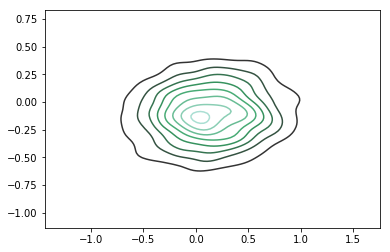

In [30]:
sns.kdeplot(samples[:,0,2,0], samples[:,11,0,3])
plt.show()

In [139]:
samples[:,10,2,0].mean()

0.09639029882481966

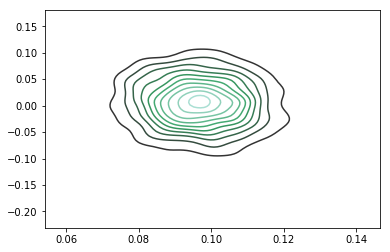

In [140]:
sns.kdeplot(samples[:,5,2,0], samples[:,5,0,0])
plt.show()

In [83]:
t = 10
# params[t]

In [84]:
np.mean(samples[:,t], axis=0)

array([[ 3.3247e-03, -7.3668e-03,  6.3002e-03,  1.1010e-02],
       [ 4.5848e-03, -3.7239e-04,  9.8147e-03,  3.6363e-03],
       [ 9.8738e-02, -1.8441e-03,  9.1986e-01,  1.1776e-04]])

In [85]:
np.std(samples[:,t], axis=0)

array([[0.0571, 0.032 , 0.0175, 0.0123],
       [0.0097, 0.0084, 0.0086, 0.0065],
       [0.0108, 0.0047, 0.024 , 0.003 ]])

In [163]:
np.mean(samples[:,t], axis=0)

array([[-0.2617, -0.0514, -0.1421, -1.1013],
       [ 0.0716,  0.1932,  0.6169,  0.2148],
       [ 0.2826, -0.0293,  0.8549,  0.9093]])

In [164]:
np.std(samples[:,t], axis=0)

array([[0.1349, 0.0932, 0.1238, 0.3107],
       [0.0814, 0.0982, 0.1407, 0.1506],
       [0.0623, 0.039 , 0.0645, 0.3178]])

In [278]:
from sklearn.neighbors.kde import KernelDensity
def score(s1, s2):
    bw = 0.1
    s1 = s1[:,np.newaxis]
    s2 = s2[:,np.newaxis]
    e1 = KernelDensity(bandwidth=bw).fit(s1)
    e2 = KernelDensity(bandwidth=bw).fit(s2)
    
    e1e2 = e1.score(s1) - e2.score(s1)
    e2e1 = e2.score(s2) - e1.score(s2)
    dist = (e1e2/len(s1) + e2e1/len(s2))/2
    return dist

In [271]:
def get_cdf(ts):
    return lambda x: (ts <= x).mean()
def score(s1,s2):
    c1 = get_cdf(s1)
    c2 = get_cdf(s2)

    m = 0
    for s in np.concatenate([s1, s2]):
        r = np.abs(c1(s) - c2(s))
        if r > m:
            m = r
    return m

In [203]:
score(s1,s2)

0.00014521624382734903

In [279]:
dists = []
for t1 in range(samples.shape[1] - 1):
    np.random.seed(1234)
    print(t1)
    t2 = t1 + 1
    s1 = samples[:,t1,0,0]
    s2 = samples[:,t2,0,0]
    ss = []
    for _ in range(10):
        s1_ = np.random.choice(s1, size=8000)
        s2_ = np.random.choice(s2, size=8000)
        m = score(s1_,s2_)
        ss.append(m)
    dists.append(ss)
dists = np.array(dists).T

0
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18


## KDE + KL

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


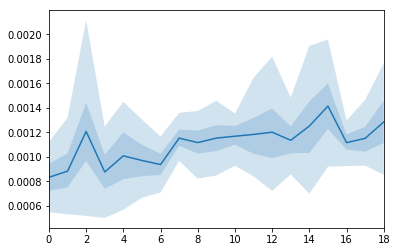

In [270]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


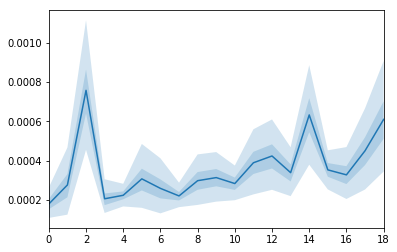

In [280]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

## Kolmogorov-Smirnov

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


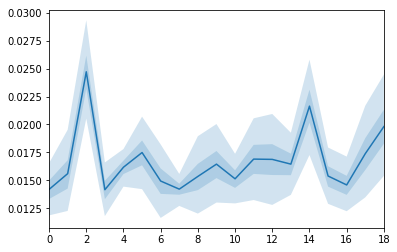

In [277]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

In [ ]:
tf.pow()